# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

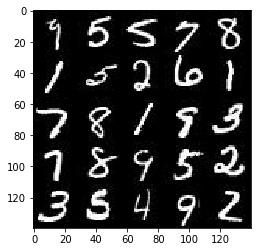

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

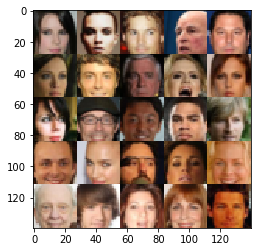

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    img = tf.placeholder(shape=[None,image_width,image_height,image_channels],dtype=tf.float32,name='img')
    z = tf.placeholder(shape=[None,z_dim],dtype=tf.float32,name='z_dim')
    lr = tf.placeholder(dtype=tf.float32)
    return img,z,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse) as scope:
        # input 28*28*3
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(x1*alpha,x1)
        # relu1 14*14
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(x2*alpha,x2)
        # relu 7*7
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(x3*alpha,x3)
        # relu 4*4*256
        
        shape_relu3 = relu3.get_shape().as_list()
        flat = tf.reshape(relu3,shape=[-1,shape_relu3[1]*shape_relu3[2]*shape_relu3[3]])
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator',reuse=not is_train) as scope:
        x1 = tf.layers.dense(z,4*4*512)
        x1 = tf.reshape(x1,shape=[-1,4,4,512])
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d_transpose(x1,128,4,strides=1,padding='valid')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        #print(x2.shape)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2,64,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        # 14*14*128
        
        x4 = tf.layers.conv2d_transpose(x3,32,5,strides=2,padding='same')
        x4 = tf.layers.batch_normalization(x4,training=is_train)
        x4 = tf.maximum(alpha*x4,x4)
        
        logits = tf.layers.conv2d_transpose(x4,out_channel_dim,3,strides=1,padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth=0.1
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if 'generator' in v.name]
    d_vars = [v for v in t_vars if 'discriminator' in v.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples,image_width,image_height,image_channel = data_shape
    n_images = 16    
    
    x,z,lr = model_inputs(image_width,image_height,image_channel,z_dim)
    d_loss,g_loss = model_loss(x,z,image_channel)
    d_opt,g_opt = model_opt(d_loss,g_loss,learning_rate,beta1)
    
    batch_count = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                input_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                batch_images *= 2.0
                feed_dict = {x:batch_images,
                             z:input_z}
                _ = sess.run(d_opt,feed_dict=feed_dict)
                _ = sess.run(g_opt,feed_dict=feed_dict)
                batch_count += 1
                
                if not batch_count%100:
                    
                    d_loss_show,g_loss_show = sess.run([d_loss,g_loss],feed_dict=feed_dict)
                    print('[epoch {epoch_i} batch {batch_count}] d_loss: {d_loss_show} , g_loss: {g_loss_show}'\
                          .format(epoch_i=epoch_i,batch_count=batch_count,d_loss_show=d_loss_show,g_loss_show=g_loss_show))
                    show_generator_output(sess, n_images, z , image_channel, data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

[epoch 0 batch 100] d_loss: 0.7566791772842407 , g_loss: 1.4151853322982788


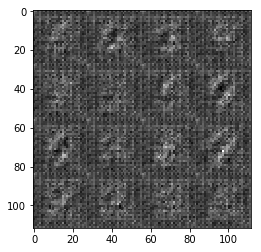

[epoch 0 batch 200] d_loss: 1.1461775302886963 , g_loss: 0.6925279498100281


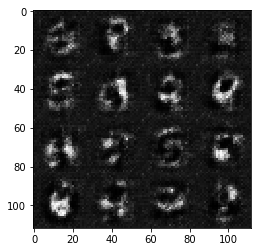

[epoch 0 batch 300] d_loss: 0.8857570290565491 , g_loss: 1.6668709516525269


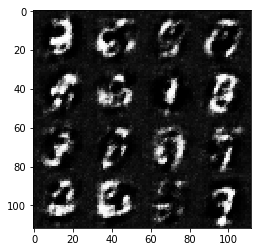

[epoch 0 batch 400] d_loss: 0.9690011739730835 , g_loss: 2.5619325637817383


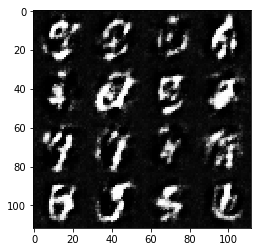

[epoch 0 batch 500] d_loss: 0.8102329969406128 , g_loss: 1.2146244049072266


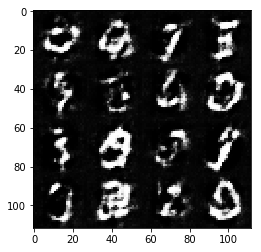

[epoch 0 batch 600] d_loss: 1.0237785577774048 , g_loss: 2.0851056575775146


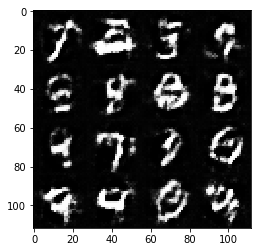

[epoch 0 batch 700] d_loss: 1.4027327299118042 , g_loss: 0.5046570897102356


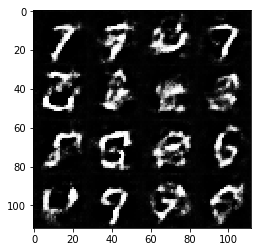

[epoch 0 batch 800] d_loss: 1.0379729270935059 , g_loss: 1.4665067195892334


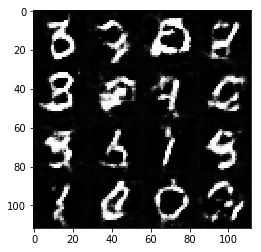

[epoch 0 batch 900] d_loss: 0.9672719240188599 , g_loss: 1.0805362462997437


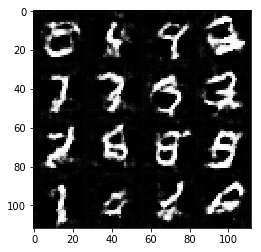

[epoch 1 batch 1000] d_loss: 0.9156772494316101 , g_loss: 1.2407623529434204


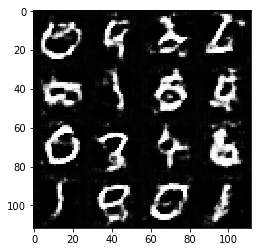

[epoch 1 batch 1100] d_loss: 1.0969231128692627 , g_loss: 1.71859610080719


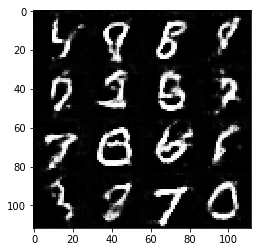

[epoch 1 batch 1200] d_loss: 0.9836464524269104 , g_loss: 0.9889119863510132


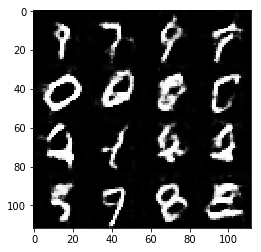

[epoch 1 batch 1300] d_loss: 0.938546359539032 , g_loss: 0.9423738121986389


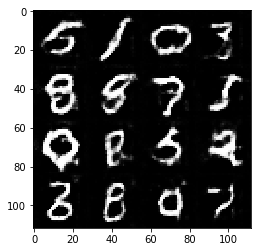

[epoch 1 batch 1400] d_loss: 0.9111509323120117 , g_loss: 1.045151710510254


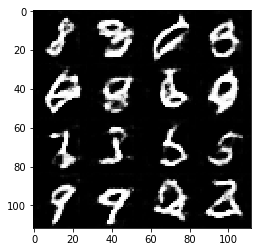

[epoch 1 batch 1500] d_loss: 0.862824022769928 , g_loss: 1.362754225730896


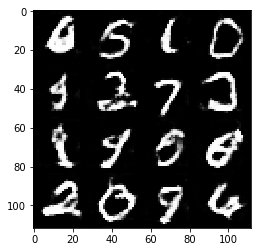

[epoch 1 batch 1600] d_loss: 0.8190599083900452 , g_loss: 1.4347338676452637


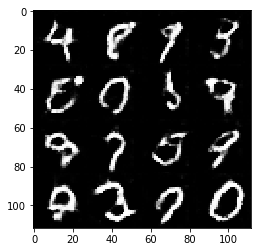

[epoch 1 batch 1700] d_loss: 0.9412316083908081 , g_loss: 1.0458694696426392


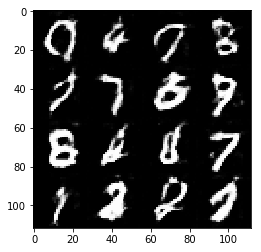

[epoch 1 batch 1800] d_loss: 1.3854080438613892 , g_loss: 0.4966948628425598


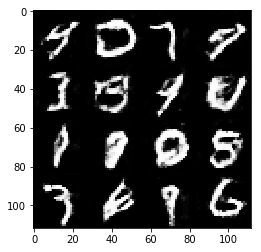

In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

[epoch 0 batch 100] d_loss: 0.45151346921920776 , g_loss: 2.707468032836914


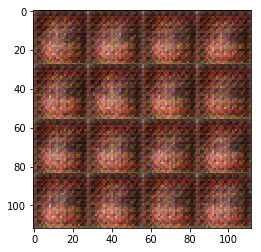

[epoch 0 batch 200] d_loss: 0.45308244228363037 , g_loss: 2.7658534049987793


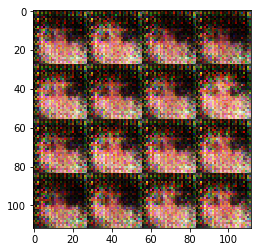

[epoch 0 batch 300] d_loss: 0.8987587690353394 , g_loss: 1.0105969905853271


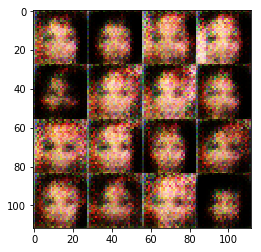

[epoch 0 batch 400] d_loss: 0.9057490229606628 , g_loss: 3.347454309463501


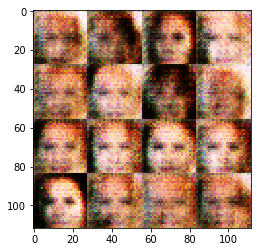

[epoch 0 batch 500] d_loss: 0.850867509841919 , g_loss: 1.1114798784255981


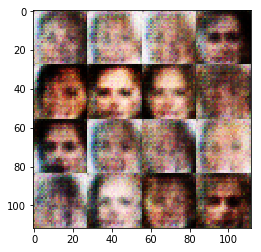

[epoch 0 batch 600] d_loss: 1.3473690748214722 , g_loss: 0.5616843700408936


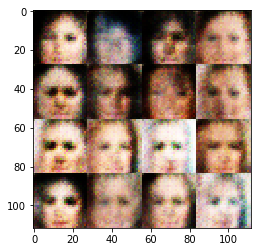

[epoch 0 batch 700] d_loss: 1.0497684478759766 , g_loss: 0.7821710705757141


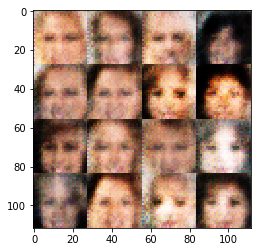

[epoch 0 batch 800] d_loss: 0.8830863833427429 , g_loss: 0.9982394576072693


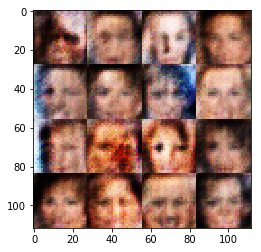

[epoch 0 batch 900] d_loss: 0.5760354995727539 , g_loss: 3.240039348602295


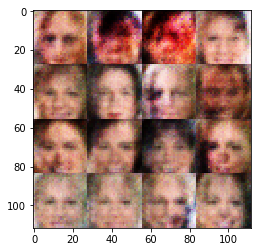

[epoch 0 batch 1000] d_loss: 0.6600704193115234 , g_loss: 1.8310534954071045


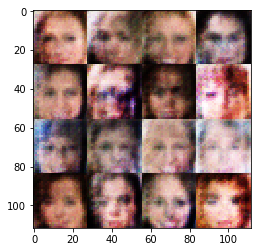

[epoch 0 batch 1100] d_loss: 1.0635141134262085 , g_loss: 2.1238133907318115


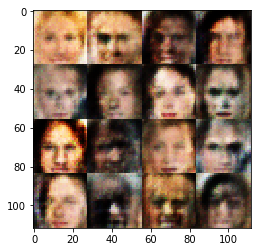

[epoch 0 batch 1200] d_loss: 0.7648804187774658 , g_loss: 1.3147639036178589


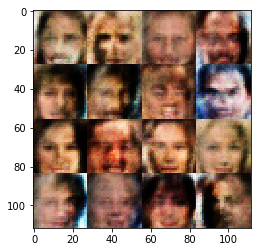

[epoch 0 batch 1300] d_loss: 0.6912031173706055 , g_loss: 1.3636435270309448


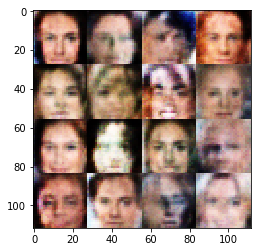

[epoch 0 batch 1400] d_loss: 0.8673166036605835 , g_loss: 0.9888877868652344


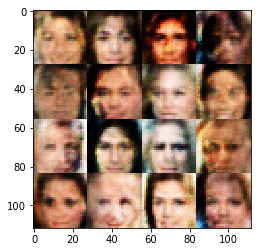

[epoch 0 batch 1500] d_loss: 0.8681676387786865 , g_loss: 0.9624018669128418


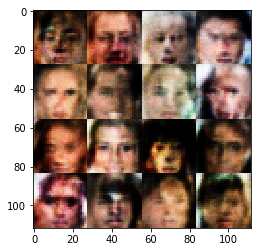

[epoch 0 batch 1600] d_loss: 0.5071343183517456 , g_loss: 2.109720230102539


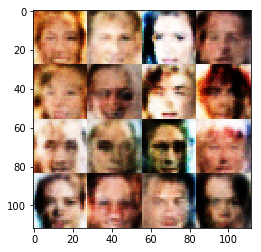

[epoch 0 batch 1700] d_loss: 0.38929283618927 , g_loss: 3.5968313217163086


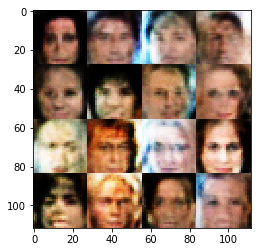

KeyboardInterrupt: 

In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。